# The weighted generalized mean model of concurrency with Raphson's method

In [1]:
%matplotlib inline

/home/dini/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [24]:
from collections import defaultdict
from pprint import pprint
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
import numpy as np

# An exhaustive study of the errors based on synthetic data
### The weighted generalized mean model

$$
M(\mathbf{x}, \mathbf{w}, p) =  
 \left\{
  \begin{array}{cl}
	\left(\sum_{i=1}^n w_i x_i^p \right)^{\frac{1}{p}}
 	& \texttt{if } p \neq 0 \\
 	\prod_{i=1}^n x_i^{w_i}
 	& \texttt{if } p=0 \\
  \end{array}
 \right.
$$
.
$$
RT(\mathbf{x}, \mathbf{w}, p, \mu,\sigma) = M(\mathbf{x}, \mathbf{w}, p)  + \exp({\mathcal{N}(\mu,\,\sigma^{2})\,})
$$
.
$$
\mathbf{x} = \exp({\mathcal{N}(...,\,...)\,})
$$


## Synthetize data with the weighted generalized mean

In [3]:
class WeightedPNormSample(object):
    
    def __init__(self, locX, scaleX, w, p, mu, sigma, training_set_size, validation_set_size, test_set_size):
        """ @param locX: location parameters of log-norm distribution of child transactions
            @param scaleX: scale parameters of log-norm distribution of child transactions
            @param w: weigth parameters of child transactions
            @param p: 
            @param mu: locataion param of log-norm additive noise
            @param sigma: scale param of log-norm additive noise
        """
        self.locX, self.scaleX, self.real_w, self.real_p, self.real_mu, self.real_sigma, = \
             locX,      scaleX,           w,           p,           mu,          sigma, 
        self.training_set_size, self.validation_set_size, self.test_set_size = \
             training_set_size,      validation_set_size,      test_set_size
            
        self.numChildren = len(locX)    
        assert self.locX.shape == (self.numChildren,)
        assert self.scaleX.shape == (self.numChildren,)
        assert self.real_w.shape == (self.numChildren,)
        if verbose:
            print "Generating {} training, {} validation and {} test samples using the following parameters:" \
                .format(training_set_size, validation_set_size, test_set_size)
            print "locX = {}        scaleX = {}".format(self.locX, self.scaleX)
            print "w = {},        p = {},        mu = {},        sigma = {}"\
                    .format(self.real_w, self.real_p, self.real_mu, self.real_sigma)
        self.train_X_samples     , self.train_RT_samples      = self._sample(training_set_size  ,) 
        self.validation_X_samples, self.validation_RT_samples = self._sample(validation_set_size,)  
        self.test_X_samples      , self.test_RT_samples       = self._sample(test_set_size      ,)

    def _sample(self, N, ):
        """ @param N: number of samples to generate
        """
        X_samples = np.stack((np.exp(np.random.normal(self.locX[child], 
                                                           self.scaleX[child], N)) 
                                   for child in range(self.numChildren)), axis=1)
        M = np.power(np.dot(np.power(X_samples, self.real_p), self.real_w), 1.0/self.real_p)
        RT_samples = M + np.exp(np.random.normal(self.real_mu, self.real_sigma, len(M)))
        return X_samples, RT_samples
  

## Raphson's method to fit the model
The fitting happens in the `__init__()` method. The Hessian is regularized with a unit matrix weighted by $\lambda$ (in the code `l_`). The iteration starts with a very strong regulazation, which is relaxed in exponential steps as the iteration progresses.

In [4]:
class WeightedPNormNR(object):
    """ Newton-raphson method to fit a weighted p-norm model. 
    
        See https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    """
    num_children = 3
    
    l = T.dscalar('lambda')  # regularization parameter
    # the model parameters
    wpm = theano.shared(np.zeros(num_children + 2), 'wpm')    #T.concatenate([w, T.stack([p, m])])

    # model parameter: weights of child transactions
    w = wpm[:num_children]
    # model parameter: power of child resp times
    p = wpm[num_children]
    # # model param: 
    # mu = theano.shared(0.0, 'mu')        # mean of normal distrib
    # sigma = theano.shared(1.0, 'sigma')  # stddev of normal
    # for now we use 
    m = wpm[num_children+1]

    # every row (selected by 0th coord) is an observation, 
    # fields in a row (1st coord) are child trx resp time in the observation
    X = T.dmatrix('X')  

    # parent resp time, each observation on a separate row
    y = T.dvector('y')

    step_size = T.dscalar('step_size')

    # The expected response time from the model we use:
    XP = T.pow(X, p)
    XPw = T.dot(XP, w)
    #sXPw = T.sum(XPw, axis=0)
    RT = T.pow(XPw, 1/p) + T.exp(m)

    # residual:
    epsilon = y - RT
    
    # penalty if sum of w is not one ...
    #regularization_1 = T.pow((w - 1.0/num_children), 2).sum()*1e-1
    # ... and if negative
    regularization_2 = T.exp((-w-.05)*100).sum() + T.exp((w-1.1)*100).sum() + T.exp(-p*100) + T.exp((p-10)*100)
    
    # Mean squared error
    MSE = 0.5 * T.pow(epsilon, 2).mean() 
    
    # the cost function
    E = MSE + regularization_2

    # the gradient:
    gradE = T.grad(E, wpm)
    
    # the hessian:
    H = T.hessian(E, wpm)    
    regularizatoin = T.diag(T.ones(num_children + 2) * l)
    Hinv = T.nlinalg.matrix_inverse(H + regularizatoin)
    
    # The inverse is computed by V.D^{-1}.U
    Hinv_gradE = T.dot(Hinv, gradE)    
    new_wpm = wpm - step_size * Hinv_gradE
    
    training_result_variables = ('wpm', 'XPw', 'RT', 'epsilon', 'regularization_2', 'MSE', 'E',  
                                 'gradE', 'Hinv', 'new_wpm', )
    train = staticmethod(theano.function(
              inputs=[X, y, step_size, l],
              outputs=[wpm, XPw, RT, epsilon, regularization_2, MSE, E, gradE, Hinv, new_wpm],
              updates=((wpm, new_wpm), )
    ))
    prediction_result_variables = 'RT', 'epsilon', 'MSE'
    predict = staticmethod(theano.function(inputs=[X, y], outputs=[RT, epsilon, MSE]))

    def __init__(self, w_init, p_init, m_init, step_size_, l_min, l_max, training_steps, data, MSE_limit):
        self.w_init, self.p_init, self.m_init, self.step_size_, self.training_steps,  self.MSE_limit = \
             w_init,      p_init,      m_init,      step_size_,      training_steps,       MSE_limit
        self.l_max, self.l_min, = l_max, l_min
            
        if verbose:
            print ("Training the model using the following parameters:"
                   "\nstep_size = {},\tlambda_min = {},\tlambda_max = {},\ttraining_steps = {}" \
                    .format(step_size_, l_min, l_max, training_steps))
            
        self.wpm.set_value(np.concatenate((self.w_init, np.stack((self.p_init, self.m_init)))))

        lambdas = sorted(np.logspace(l_min, l_max, self.training_steps), reverse=True)
        for i, l_ in zip(range(self.training_steps), lambdas):
            result = WeightedPNormNR.train(data.train_X_samples, data.train_RT_samples, self.step_size_, l_)
            wpm, XPw, RT, epsilon, regularization_2, MSE, E, gradE, Hinv, new_wpm = result
            if MSE < MSE_limit:
                break

        self.training_results = dict(zip(self.training_result_variables, result))
        self.training_results['i'] = i
        if verbose:
            print "MSE = {}".format(self.training_results['MSE'])

    def __call__(self, data):
        prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
        return dict(zip(self.prediction_result_variables, prediction_result))
        
        
    @classmethod
    def evaluate_init(cls, step_size, training_steps, data, N):
        """ Determine how the starting point of the iteration impacts the end-result.
        """
        results = defaultdict(list)
        for i in range(N):
            w_init = np.random.uniform(0, 1, cls.num_children)
            p_init = np.random.uniform(0.4, 4)
            m_init = np.random.uniform(-5, 5)
            wpn = WeightedPNormGradDesc(w_init, p_init, m_init, step_size, training_steps, data)
            results['w'].append(w)
            results['p'].append(p)
            results['mu'].append(m)  # (m, data.real_mu + data.real_sigma^2 /2)

        pass  # plot RT_samples vs. RT_predictions
        pass  # plot the distribution of epsilon    
        return results
    
    @classmethod
    def evaluate_real(cls, step_size, l_min, l_max, training_steps, N, MSE_limit, real_sigma = 0.0):
        """ Determine how the real values of the model parameters impact the error.
        """
        w_init = np.ones(cls.num_children) / cls.num_children
        p_init = 1.0
        m_init = 0.0
        results = list() 
        for i in range(N):
            if verbose:
                print "i = {}".format(i)
            locX = np.random.uniform(-1, 1, cls.num_children)
            scaleX = np.random.uniform(0, 2, cls.num_children)
            real_w = np.random.uniform(0, 1, cls.num_children)
            real_p = np.random.uniform(0.4, 4)
            real_mu = np.random.uniform(-1, 1)
            data = WeightedPNormSample(locX, scaleX, real_w, real_p, real_mu, real_sigma, 
                                       training_set_size=5000, 
                                       validation_set_size=0, 
                                       test_set_size=5000)
            wpn = WeightedPNormNR(w_init, p_init, m_init, step_size, l_min, l_max, training_steps, data, MSE_limit)
            results.append( (data, wpn.training_results, wpn(data)))
        return results    

## Evaluate the fitting algorithm on noisless data
### Generate data points for the evaluation
For each data point:

- a random value for the parameters locX, scaleX, real_w, real_p, real_mu, real_sigma is chosen
- a training and a test data sets are generated
- the model is fit to the training data
- a prediction is generated on the test data using the fit model

In [5]:
verbose = True
results = WeightedPNormNR.evaluate_real(step_size=.05, l_min=-2, l_max=4, training_steps = 500, N=50, MSE_limit=0.01)

i = 0
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [ 0.70516142 -0.73527072  0.82082894]        scaleX = [ 0.27342698  0.18187215  0.91894829]
w = [ 0.34931777  0.8003433   0.64214865],        p = 1.53933965255,        mu = -0.539104804553,        sigma = 0.0
Training the model using the following parameters:
step_size = 0.05,	lambda_min = -2,	lambda_max = 4,	training_steps = 500
MSE = 0.00991584100435
i = 1
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [ 0.2898774   0.67985393 -0.56887872]        scaleX = [ 1.5613282   0.0497173   1.09436079]
w = [ 0.22032135  0.72799184  0.39382157],        p = 2.72105926186,        mu = 0.255844240135,        sigma = 0.0
Training the model using the following parameters:
step_size = 0.05,	lambda_min = -2,	lambda_max = 4,	training_steps = 500
MSE = 0.00994461603494
i = 2
Generating 5000 training, 0 validation and 5000 test samples using the fo

There seems to be a lot of room for playing with the `step_size`, `training_steps` and regularization parameters of the algorithm: there is still potential to improve the MSE.
### Examine the mean squared error on the training and test data sets

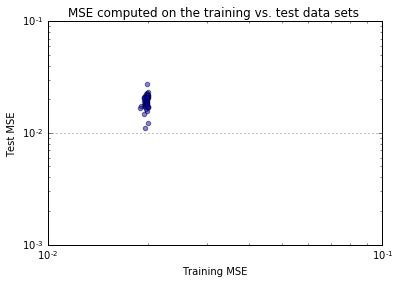

In [64]:
def plot_MSE_vs_MSE(results):
    series = defaultdict(list)
    for data, wpn_results, prediction_results in results:
        series['MSE'].append((2.0*wpn_results['MSE'], 2.0*prediction_results['MSE'], ))
    
    for parameter, data in series.items():
        plt.title('MSE computed on the training vs. test data sets ')
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.scatter(*zip(*data), alpha=0.5)
        plt.xlabel('Training MSE')
        plt.ylabel('Test MSE')
        plt.show()
plot_MSE_vs_MSE(results)

The iteration converged to an MSE below the given limit of $0.01$ in each of the 50 trials! None of the cases resulted in $MSE=NaN$.

The MSE achieved on the test data is comparable with that of the training.

### Examine the dependence of the MSE on the actual model parameters
Is there a particular domain of some of the parameters that cause a higher-than-usual MSE?

In [57]:
def plot_MSE_vs_real(results):
    series = defaultdict(list)
    for data, wpn_results, prediction_results in results:
        series['w_0'].append((data.real_w[0], 2.0*prediction_results['MSE'], ))
        series['w_1'].append((data.real_w[1], 2.0*prediction_results['MSE'], ))
        series['w_2'].append((data.real_w[2], 2.0*prediction_results['MSE'], ))
        series['p'  ].append((data.real_p   , 2.0*prediction_results['MSE'], ))
        series['m'  ].append((data.real_mu + data.real_sigma**2.0/2, 2.0*prediction_results['MSE'], ))
    
    for parameter, data in series.items():
        plt.title('Dependence of the MSE on the actual value of {}'.format(parameter))
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel(parameter)
        plt.ylabel('Test MSE')
        plt.show()

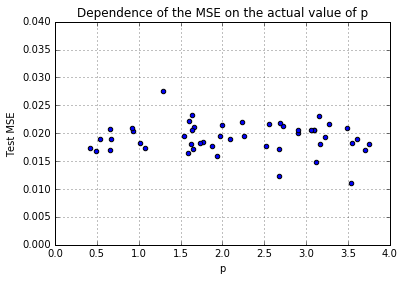

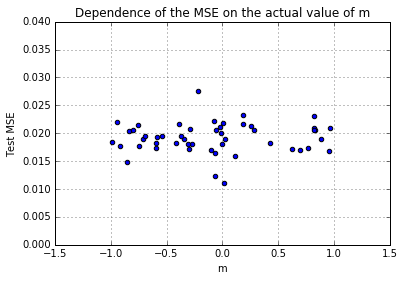

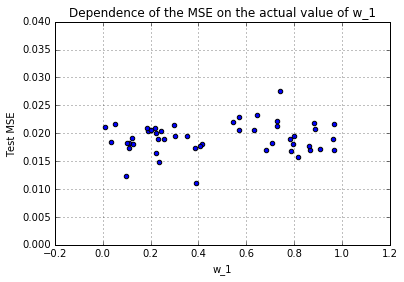

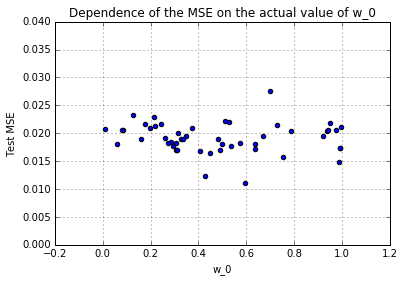

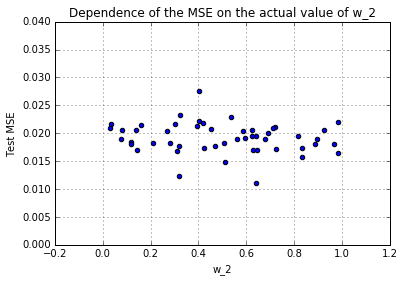

In [58]:
plot_MSE_vs_real(results)

There seems to be no particular domain of any of the parameters that cause high MSE.

### Examine the actual vs. the recovered model parameters

In [9]:
def plot_actual_vs_prediction(results):
    series = defaultdict(list)
    for data, training_results, prediction_results in results:
        series['w_0'].append((training_results['wpm'][0], data.real_w[0], ))
        series['w_1'].append((training_results['wpm'][1], data.real_w[1], ))
        series['w_2'].append((training_results['wpm'][2], data.real_w[2], ))
        series['p'  ].append((training_results['wpm'][3], data.real_p, ))
        series['m'  ].append((training_results['wpm'][4], data.real_mu + data.real_sigma**2.0/2, ))
    
    for title, data in series.items():
        plt.title(title)
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel('prediction')
        plt.ylabel('actual')
        plt.show()

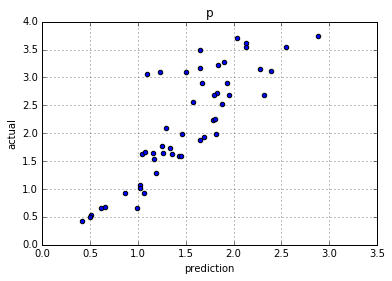

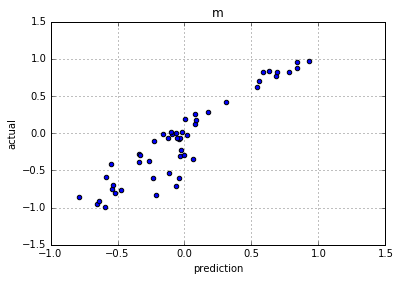

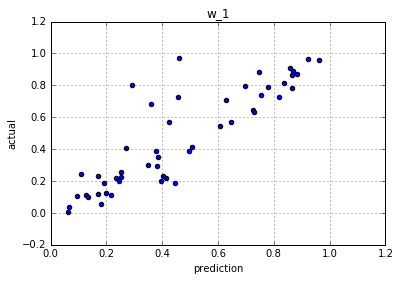

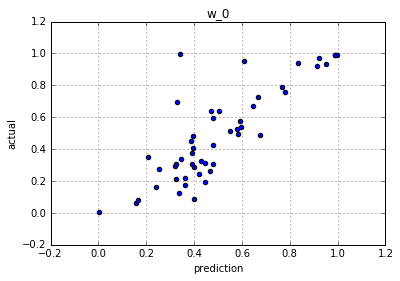

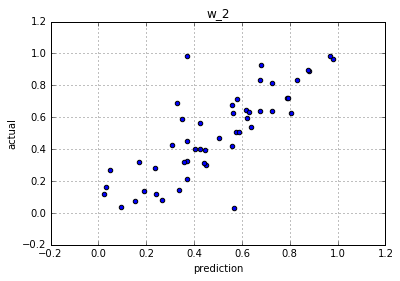

In [10]:
plot_actual_vs_prediction(results)

All we can say is that the predictions of the fit model are acceptable. The model parameters are recovered with large errors. By visual inspection, the most accurately recovered parameter is $m$.
## Evaluate the fitting algorithm on noisy data

In [11]:
verbose = True
noisy_results = WeightedPNormNR.evaluate_real(step_size=.05, l_min=-2, l_max=4, training_steps = 500, N=50, MSE_limit=0.01, 
                                        real_sigma = 1.0)

i = 0
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [ 0.35266865  0.34657041 -0.25558402]        scaleX = [ 1.00356439  1.69198904  1.25750704]
w = [ 0.46686804  0.19518368  0.8175986 ],        p = 3.90372592126,        mu = 0.10556406977,        sigma = 1
Training the model using the following parameters:
step_size = 0.05,	lambda_min = -2,	lambda_max = 4,	training_steps = 500
MSE = 2.89928693881
i = 1
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [-0.04435472 -0.46993719 -0.21539852]        scaleX = [ 1.71610114  1.64417974  0.94775695]
w = [ 0.98811473  0.34720468  0.92341155],        p = 0.580342371579,        mu = -0.201673229299,        sigma = 1
Training the model using the following parameters:
step_size = 0.05,	lambda_min = -2,	lambda_max = 4,	training_steps = 500
MSE = 1.66905695128
i = 2
Generating 5000 training, 0 validation and 5000 test samples using the following pa

### Compare the training MSE to the best achievable value and to the test MSE
The variance of the additive log normal noise is a lower bound on the training MSE and it is dependent both on the location and the scale parameters:

$$(e^{\sigma^2}  − 1)\cdot e^{2\mu+\sigma^2}$$

Let's calculate this lower bound and compare the training MSE to it!

In [46]:
def log_normal_variance(mu, sigma):
    sigma2 = sigma * sigma
    return (np.exp(sigma2) - 1) * np.exp(2.0*mu + sigma2)

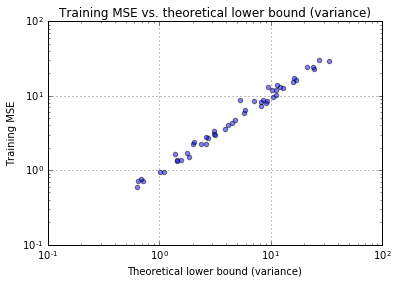

In [63]:
def plot_MSE_vs_variance(results):
    data = list()
    for wpn_sample, training_results, prediction_results in results:
        data.append((log_normal_variance(wpn_sample.real_mu,  wpn_sample.real_sigma), 2.0*training_results['MSE'],) )
    
    plt.title('Training MSE vs. theoretical lower bound (variance)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.scatter(*zip(*data), alpha=0.5)
    plt.xlabel('Theoretical lower bound (variance)')
    plt.ylabel('Training MSE')
    plt.show()
        
plot_MSE_vs_variance(noisy_results)

The MSE is a lot higher, which is expected, but it is always close to its theoretical lower bound, so the training approached the global optimum.

Now compare the test and training MSEs:

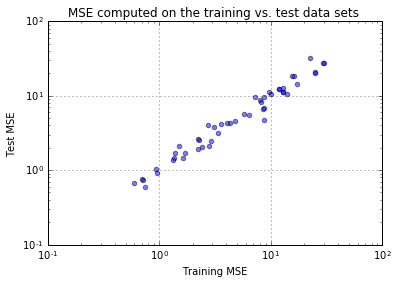

In [66]:
plot_MSE_vs_MSE(noisy_results)

The test error is approximately the same as the training error, so we fit the parameter to the mechanism generating the data, not to the noise.

### Dependence of the MSE on the actual model parameters

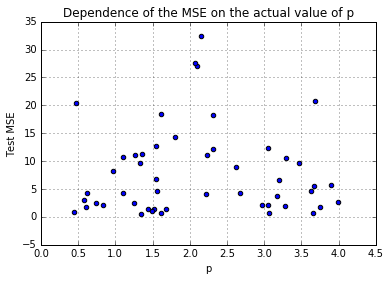

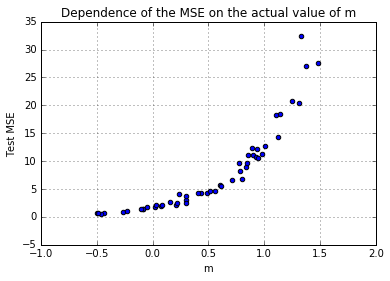

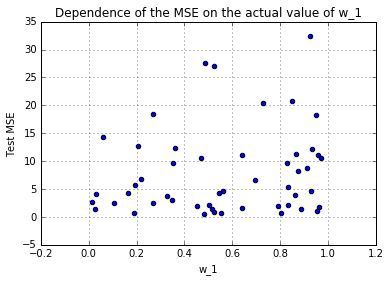

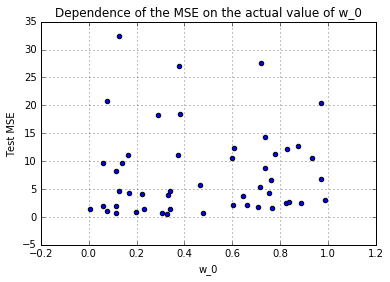

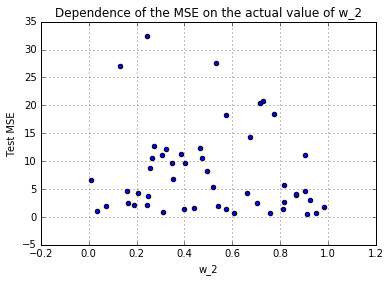

In [68]:
plot_MSE_vs_real(noisy_results)

Unlike in the noise-free case, the MSE shows an exponential relationship to the mean of the additive noise, which is expected.

### Actual vs. the recovered model parameters

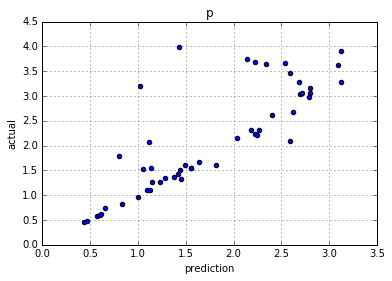

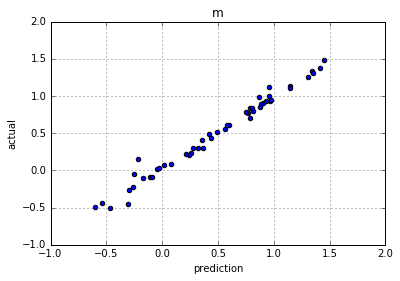

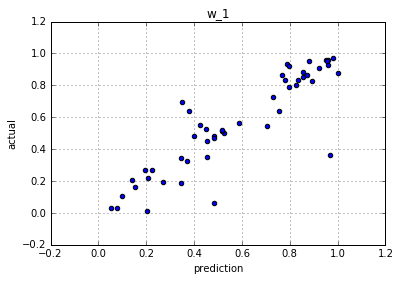

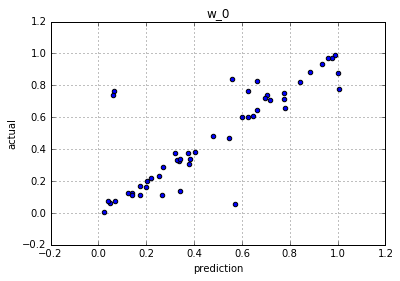

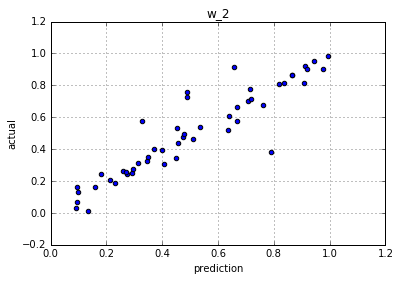

In [69]:
plot_actual_vs_prediction(noisy_results)

The recovery of the model parameters seems to be more accurate than without the additive noise. Is this some kind of [dither](https://en.wikipedia.org/wiki/Dither) effect?

# Summary
The method looks promising. The MSE values attained are near their theoretical lower bound. 

It was necessary to apply some heuristic tuning of the regularization parameter during the iterations of the NR algorithm. Improvements in the speed of convergence can be expected from involving the step size in the tuning.

Although these results are better than the ones obtained with gradient descent, there I auto-tuned neither the regularization parameter nor the step size. We cannot conclude that the NR method is better than gradient descent.

Remaining questions:

* Can the model be fit to data generated by other models of concurrency (and eventually to real data)?